In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('datapath.txt', 'r') as f:
    datapath = f.readlines()[0].strip()

In [3]:
foster_care_path = 'CYF Active 2010 to 2016-11-09(1).csv'

In [4]:
foster_care = pd.read_csv(datapath + foster_care_path)

In [5]:
homeless_path = 'HomelessShelters(1).csv'

In [6]:
homeless = pd.read_csv(datapath + homeless_path)

Drop CL_ID, should be redundent. Maybe could help merge with other datasets?

In [7]:
foster_care.drop('CL_ID', axis=1, inplace=True)

A bunch of the MCI_ID are zero. This seems to be a wastebasket MCI id

In [8]:
foster_care[foster_care['MCI_ID'] == 0].shape

(6859, 8)

In [9]:
foster_care = foster_care[foster_care['MCI_ID'] > 0.0]

Data dictionary says "Ignore IDs that are less than 10 digits -- those are source system and you will not be able to link". I'm just dropping them.

In [10]:
homeless = homeless[homeless['MCI_ID_OR_HMIS_CLIENT_ID'] >= 1e9]

### Merging in demographic info 

The demographic columns (Birth date, gender, and race) are individual specific and consistent for each entry of the individual. That info is really easy to merge.

In [11]:
demographic_col = [u'BRTH_DT', u'GENDER', u'RACE']

This is an individual-based table of the three demographic factors.

In [12]:
demo_lookup = pd.DataFrame([foster_care.groupby('MCI_ID')[i].unique().map(lambda x: x[0])
                            for i in demographic_col], index=demographic_col).T #There has to be a more pythonic way of doing this

I did an inner join, so I'm going to just have the people that have interacted both with CYF and the shelter system.

In [13]:
homeless_joined = homeless.join(demo_lookup, on='MCI_ID_OR_HMIS_CLIENT_ID', how='inner')

I didn't convert the dates yet...

In [14]:
dt_episode_start = pd.to_datetime(homeless_joined['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce')
dt_birth_date = pd.to_datetime(homeless_joined['BRTH_DT'], errors='coerce')

And now I can find the age in years when the homeless episode started.

In [36]:
homeless_joined['age_at_episode_start'] = ((dt_episode_start
                                     - dt_birth_date).dt.days / 365)

In [38]:
homeless_joined['GENDER'].unique()

array(['Female', 'Male'], dtype=object)

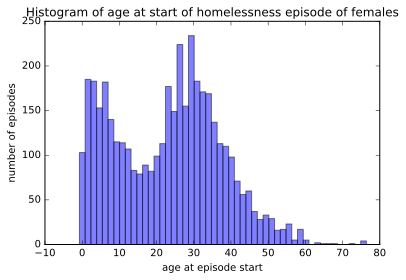

In [42]:
females = homeless_joined[homeless_joined['GENDER'] == 'Female']
plt.hist(females['age_at_episode_start'].dropna(), bins=50, alpha=0.5)
plt.xlabel('age at episode start')
plt.ylabel('number of episodes')
plt.title('Histogram of age at start of homelessness episode of females')
plt.show()


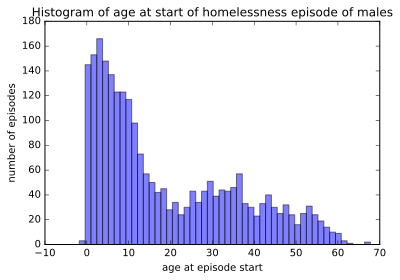

In [43]:
males = homeless_joined[homeless_joined['GENDER'] == 'Male']
plt.hist(males['age_at_episode_start'].dropna(), bins=50, alpha=0.5)
plt.xlabel('age at episode start')
plt.ylabel('number of episodes')
plt.title('Histogram of age at start of homelessness episode of males')
plt.show()



In [ ]:
plt.hist(age_at_episode_start.values, bins=50, alpha=0.5)
plt.xlabel('age at episode start')
plt.ylabel('number of episodes')
plt.title('Histogram of age at start of homelessness episode')
plt.show()


In [ ]:
unique_homeless_mci = homeless['MCI_ID_OR_HMIS_CLIENT_ID'].unique()

In [ ]:
unique_foster_mci = foster_care['MCI_ID'].unique()

In [ ]:
sum([i in unique_foster_mci for i in unique_homeless_mci])

In [ ]:
cyf_groupby = foster_care.groupby('MCI_ID')

In [ ]:
plt.hist?

In [ ]:
pd.to_datetime(foster_care['INVLV_STRT_DT'], errors='coerce').hist()

In [ ]:
foster_care.columns

In [ ]:
pd.to_

In [ ]:
pd.to_datetime(foster_care[''], errors='coerce').min()

In [ ]:
homeless['PROJ_INVOLVEMENT_EPISODE_START'].min()

In [ ]:
homeless

In [ ]:
age_at_episode_start.hist?

In [ ]:
age_values = age_at_episode_start.dropna().values

In [ ]:
age_values

In [ ]:
pd.to_datetime(foster_care['INVLV_END_DT'], errors='coerce')

In [ ]:
(cyf_groupby['INVLV_STRT_DT'].count()>1).sum()

In [ ]:
demo_lookup['N_CYF_CASES'] = cyf_groupby['INVLV_STRT_DT'].count()

In [ ]:
def date_diff(s):
    pd.to_datetime(s['INVLV_END_DT']) - pd.to_datetime(s)

In [ ]:
demo_lookup['']

In [ ]:
demo_lookup.shape

In [ ]:
homeless.columns

In [ ]:
homeless[~homeless[demographic_col[0]].isnull()]['MCI_ID_OR_HMIS_CLIENT_ID'].nunique() / homeless['MCI_ID_OR_HMIS_CLIENT_ID'].nunique()

In [ ]:
pd.to_datetime?

In [ ]:
homeless.loc[845, 'PROJ_INVOLVEMENT_EPISODE_START']

In [ ]:
homeless.head()

In [ ]:
homeless['PROJ_INVOLVEMENT_EPISODE_START'] = pd.to_datetime(homeless['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce')

In [ ]:
homeless['PROJ_INVOLVEMENT_EPISODE_END'] = pd.to_datetime(homeless['PROJ_INVOLVEMENT_EPISODE_END'], errors='coerce')

In [ ]:
homeless.groupby('GENDER').describe()

In [ ]:
homeless[~homeless[demographic_col[0]].isnull()]['MCI_ID_OR_HMIS_CLIENT_ID'].nunique()

In [ ]:
homeless['MCI_ID_OR_HMIS_CLIENT_ID'].nunique()

In [ ]:
homeless.shape

In [ ]:
homeless.dropna().shape

In [ ]:
(demo_lookup.applymap(lambda x: len(x)) != 1).sum()

In [ ]:
foster_care[foster_care]

In [ ]:
foster_care.columns

In [ ]:
unique_demo = pd.DataFrame([foster_care.groupby('MCI_ID')[i].nunique()
                            for i
                            in demographic_col], index=demographic_col).T

In [ ]:
foster_care.groupby('MCI_ID').

In [ ]:
(unique_demo > 1).sum()

In [ ]:
Out[36].shape

In [ ]:
foster_care.groupby('MCI_ID').apply(lambda x: x.iloc[0])

In [ ]:
(foster_care.groupby('MCI_ID')['GENDER'].nunique() != 1)